In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import pprint
import sqlite3
import math
from tqdm import tqdm
from datetime import datetime
# from Offline.strategies.ml_based_strategy_latest_多任务策略 import CustomMLStrategy
from Offline.strategies.ml_based_strategy_latest_回归策略 import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer
from Share.database.downloader.downloader_base import DownloaderBase
import Share.database.database_config as db_config

In [2]:
# model_pred_df = pd.read_pickle('./backtest_data/test/000905_stock_selection_results_20200101.pkl')
# ---- 回归任务
# model_pred_df = pd.read_pickle('./backtest_data/test/000016_20190101_回归任务.pkl')
model_pred_df = pd.read_pickle('./backtest_data/test/000905_20190101_回归任务.pkl')
# ---- 多任务
# model_pred_df = pd.read_pickle('./backtest_data/test/000016_20190101_多任务.pkl')

In [3]:
# model_pred_list = []
# pred_dir = f'./backtest_data/{BACKTEST_INDEX_SYMBOLS}/'
# for file_name in sorted(os.listdir(pred_dir)):
#     print(file_name)
#     model_pred_list.append(pd.read_pickle(pred_dir+f'{file_name}'))
# model_pred_df = pd.concat(model_pred_list)

In [4]:
# # 计算每日选择TopBuyN & TopSellN
# def get_model_prediction(dataframe, n=5):
#     def get_stock_for_buy(group):
#         filtered_group = group[group["label_pred"] > 0.0]
#         top_n = filtered_group.nlargest(n, "label_pred")
#         return top_n.to_dict("records")

#     def get_stock_for_sell(group):
#         filtered_group = group[group["label_pred"] < 0.0]
#         bottom_n = filtered_group.nsmallest(n, "label_pred")
#         return bottom_n.to_dict("records")

#     model_prediction = dataframe
#     stock_for_buy = model_prediction.groupby("datetime").apply(get_stock_for_buy).to_dict()
#     stock_for_sell = model_prediction.groupby("datetime").apply(get_stock_for_sell).to_dict()
#     return stock_for_buy, stock_for_sell

# buy_df, sell_df = get_model_prediction(model_pred_df)

In [5]:
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].unique().tolist()
BACKTEST_START_DATE = datetime.strptime(model_pred_df['datetime'].min(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测开始日期
BACKTEST_END_DATE = datetime.strptime(model_pred_df['datetime'].max(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测结束日期
print(f'Start: {BACKTEST_START_DATE}, End: {BACKTEST_END_DATE}')
BACKTEST_DATETIME_INDEX = pd.date_range(start=BACKTEST_START_DATE, end=BACKTEST_END_DATE, freq='B')

Start: 20190102, End: 20231215


In [6]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database/hh_quant.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)

cerebro = bt.Cerebro()
BACKTEST_INITIAL_CASH = 100000  # 初始化资金
BACKTEST_INDEX_SYMBOLS = "000905"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身

print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型
cerebro.broker.set_slippage_perc(perc=0.0001) # 配置自定义的滑点类型

print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_stock_history_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data = stock_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

print("开始添加基准数据...")
benchmark_data = db_downloader._download_index_history_info(BACKTEST_INDEX_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data = benchmark_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
benchmark_name = f"benchmark_{BACKTEST_INDEX_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

# print("开始添加观察器...")
# cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

开始设置回测基础参数...
开始添加回测股票数据...


100%|██████████| 428/428 [00:02<00:00, 184.06it/s]

开始添加基准数据...
开始添加分析器...


In [7]:
print("开始添加策略...")
strategy_params = {
    "benchmark": benchmark_name,
    "model_pred_dataframe": model_pred_df,
}

strategy_params.update(
    {
        "max_position_proportion": 0.15,  # 最大持仓资金占比
        "min_holding_period": 3,  # 最小持仓周期
        "max_holding_period": 30,  # 最大持仓周期
        "top_n": 5,  # 每日选择股票的TopN
        "min_buy_cash": 1000,  # 最小购买资金限制
        "atr_period": 14,  # ATR计算周期
        "atr_take_profit_factor": 3,  # ATR止盈因子
        "atr_stop_loss_factor": 1.5,  # ATR止损因子
        "atr_risk": 0.15,  # ATR风险系数
        "label_pred_threshold": 0, # 人工定义的预测threshold
    }
)

cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


0

In [8]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...
启动基准对比...
回测数据共: 428
current_date: 2019-01-02 ================================================================================
today_buy_stocks: ['600863', '002653', '600131', '002030', '000537', '002262', '600499', '601233', '300677', '002353']
current_cash: 100000.0
2019-01-03 买入执行, 引用: 1, 价格: 29.36, 成本: 9953.76, 手续费: 5.00, 数量: 339.00, 股票: 600863
2019-01-03 买入执行, 引用: 2, 价格: 31.76, 成本: 9495.10, 手续费: 5.00, 数量: 299.00, 股票: 002653
2019-01-03 买入执行, 引用: 3, 价格: 23.87, 成本: 10027.41, 手续费: 5.00, 数量: 420.00, 股票: 600131
2019-01-03 买入执行, 引用: 4, 价格: 101.34, 成本: 9424.81, 手续费: 5.00, 数量: 93.00, 股票: 002030
2019-01-03 买入执行, 引用: 5, 价格: 25.62, 成本: 8584.03, 手续费: 5.00, 数量: 335.00, 股票: 000537
2019-01-03 买入执行, 引用: 6, 价格: 70.60, 成本: 7836.55, 手续费: 5.00, 数量: 111.00, 股票: 002262
2019-01-03 买入执行, 引用: 7, 价格: 89.21, 成本: 7314.85, 手续费: 5.00, 数量: 82.00, 股票: 600499
2019-01-03 买入执行, 引用: 8, 价格: 29.00, 成本: 6961.01, 手续费: 5.00, 数量: 240.00, 股票: 601233
2019-01-03 买入执行, 引用: 9, 价格: 29.34, 成本: 6484.37, 手续费: 5.00, 数量: 22

开始打印回测相关指标...
Start Portfolio Value: 100000
Final Portfolio Value: 230144.47553512547
{'其他': {'亏损次数': 2050,
        '夏普比率': 1.0675,
        '日均超额收益': 0.0004,
        '日胜率': 0.5209,
        '最大回撤': 22.0789,
        '最大回撤区间': 95,
        '盈亏比': 2.2599,
        '盈利次数': 1355,
        '索提诺比率': 1.4698,
        '胜率': 0.3979,
        '贝塔': 0.7032,
        '超额收益': 0.9825,
        '超额收益夏普比率': 0.9634,
        '阿尔法': 0.0005},
 '基准': {'基准年化收益': 0.0554, '基准收益': 0.3189, '基准波动率': 0.198},
 '策略': {'策略年化收益': 0.1764, '策略收益': 1.3014, '策略波动率': 0.1651}}


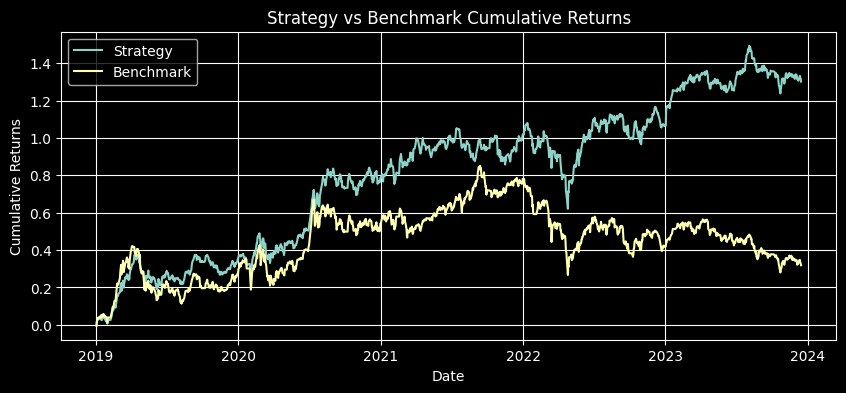

In [9]:
print("开始打印回测相关指标...")
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.get_value()}")

def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)

In [10]:
annual_strategy_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_benchmark_returns = benchmark_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns = pd.concat([annual_strategy_returns, annual_benchmark_returns], axis=1)
annual_returns.columns = ['Strategy', 'Benchmark']
annual_returns['Gap'] = annual_returns['Strategy'] - annual_returns['Benchmark']
annual_returns

,Strategy,Benchmark,Gap
2019-12-31,0.349708,0.274859,0.074849
2020-12-31,0.322776,0.208717,0.114059
2021-12-31,0.130600,0.155846,-0.025246
2022-12-31,0.024555,-0.203133,0.227688
2023-12-31,0.112833,-0.070711,0.183544


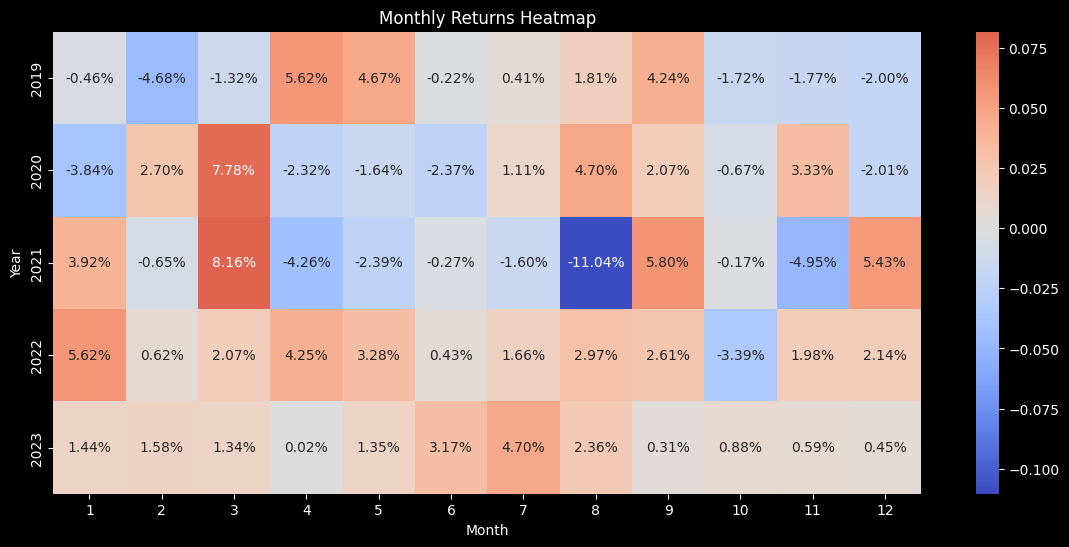

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 monthly_returns 是一个包含月度收益率的Series，并且它的索引是DateTimeIndex
# 如果它不是DataFrame，我们先将其转换成DataFrame
strategy_monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
benchmark_monthly_returns = benchmark_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
gap_monthly = strategy_monthly_returns - benchmark_monthly_returns

monthly_returns_df = gap_monthly.to_frame(name='收益率差')

# 创建新的列来代表年份和月份
monthly_returns_df['Year'] = monthly_returns_df.index.year
monthly_returns_df['Month'] = monthly_returns_df.index.month

# 使用pivot方法来创建适合热力图的DataFrame
pivot_table = monthly_returns_df.pivot(index='Year', columns='Month', values='收益率差')

# 使用Seaborn绘制热力图
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='coolwarm', center=0)
plt.title('Monthly Returns Heatmap')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()


In [12]:
# !nvidia-smi